In [5]:
import numpy as np
import pandas as pd
from itertools import combinations

In [4]:
nstate=4
csv_filename = 'hddm2_fixed_final_' + str(nstate) + 'states.csv'

# Load synthetic RLSSM dataset containing both behavioral data and ground truth parameters
# savefile = np.load(csv_filename, allow_pickle=True)
dataset = pd.read_csv(csv_filename, index_col=0)
dataset

,subj_idx,rt1,rt2,response1,response2,state1,state2,feedback,trial,cond,q_init,isleft1,isleft2,split_by
1,0.0,1.111,1.223,1.0,1.0,1.0,2.0,1.0,0.0,1.0,0.5,1.0,0.0,1.0
2,0.0,0.955,1.140,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.5,0.0,0.0,1.0
3,0.0,1.273,0.731,1.0,1.0,0.0,1.0,1.0,2.0,1.0,0.5,0.0,1.0,1.0
4,0.0,0.752,0.705,0.0,1.0,3.0,1.0,1.0,3.0,1.0,0.5,0.0,1.0,1.0
5,0.0,1.201,1.401,0.0,1.0,2.0,0.0,1.0,4.0,1.0,0.5,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30503,107.0,0.434,0.685,0.0,0.0,0.0,0.0,0.0,292.0,1.0,0.5,0.0,0.0,1.0
30504,107.0,0.534,1.022,0.0,1.0,1.0,2.0,1.0,293.0,1.0,0.5,1.0,0.0,1.0
30505,107.0,0.472,0.609,0.0,0.0,2.0,3.0,0.0,294.0,1.0,0.5,0.0,1.0,1.0
30506,107.0,0.416,0.769,0.0,0.0,2.0,0.0,1.0,295.0,1.0,0.5,1.0,1.0,1.0


In [ ]:


n = 4

pairs = list(combinations(range(n), 2))

# [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [7]:
pairs

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [25]:
import numpy as np
from itertools import combinations

def running_beta_variance_by_pair(dataset, alpha0=1.0, beta0=1.0):
    """
    Returns a trial-wise time series of Beta variances for 'common' probability
    per first-stage pair, using a Beta–Bernoulli update.

    Inputs expected in `dataset`:
      - state1: index of the presented pair (0..K-1 over combinations)
      - response1: which element of the pair was chosen (0 or 1)
      - state2: observed second-stage state (0..n-1)

    Variance at trial t is computed BEFORE updating with trial t.
    """
    # Build all unordered pairs and map each trial to its pair
    n = int(dataset["state2"].max()) + 1
    pairs = np.array(list(combinations(range(n), 2)), dtype=np.int64)  # (K,2)
    K = len(pairs)

    pair_idx = dataset["state1"].to_numpy(dtype=np.int64)   # (T,)
    resp     = dataset["response1"].to_numpy(dtype=np.int64)  # 0/1
    s2       = dataset["state2"].to_numpy(dtype=np.int64)   # (T,)

    trial_pairs = pairs[pair_idx]                            # (T,2)
    rows = np.arange(trial_pairs.shape[0])
    chosen_state = trial_pairs[rows, resp]                   # (T,)
    is_common = (s2 == chosen_state).astype(np.int64)        # (T,)

    # Running Beta update per pair
    alpha = np.full(K, alpha0, dtype=float)
    beta  = np.full(K, beta0, dtype=float)
    var_ts = np.empty(len(pair_idx), dtype=float)

    for t, k in enumerate(pair_idx):
        a, b = alpha[k], beta[k]
        var_ts[t] = (a * b) / ((a + b)**2 * (a + b + 1.0))   # variance before observing trial t
        if is_common[t]:
            alpha[k] = a + 1.0
        else:
            beta[k] = b + 1.0

    return var_ts  # shape: (n_trials,)

In [ ]:
subjects = dataset['subj_idx'].unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  43.,  44.,  45.,
        46.,  48.,  49.,  50.,  51.,  53.,  54.,  55.,  56.,  58.,  59.,
        60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,
        71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,
        82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,
        93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
       104., 105., 106., 107.])

In [29]:
subjects = dataset['subj_idx'].unique()
for s, subjects in enumerate(subjects):
    print(f"Subject {s}: {subjects}")
    subject_data = dataset[dataset['subj_idx'] == subjects]
    uncertainty_ts = running_beta_variance_by_pair(subject_data, alpha0=1.0, beta0=1.0)
    print(f"Uncertainty time series for subject {s}: {uncertainty_ts}")
    dataset.loc[dataset['subj_idx'] == subjects, 'uncertainty'] = uncertainty_ts

Subject 0: 0.0
Uncertainty time series for subject 0: [0.08333333 0.08333333 0.05555556 0.08333333 0.08333333 0.05555556
 0.0375     0.05555556 0.0375     0.08333333 0.05       0.02666667
 0.05555556 0.01984127 0.0375     0.08333333 0.01530612 0.05555556
 0.04       0.05555556 0.03174603 0.01215278 0.02666667 0.01728395
 0.01454545 0.05       0.04       0.01984127 0.01530612 0.04
 0.01215278 0.05       0.01239669 0.04       0.03174603 0.00987654
 0.01068376 0.0255102  0.03061224 0.02604167 0.02222222 0.02083333
 0.02181818 0.03571429 0.01267963 0.01728395 0.01360544 0.03061224
 0.03571429 0.02777778 0.01454545 0.01928375 0.01388889 0.03061224
 0.02469136 0.00818182 0.01239669 0.02272727 0.01709402 0.01521555
 0.01360544 0.01068376 0.01263787 0.02066116 0.00688705 0.01222222
 0.01869658 0.01775148 0.01153403 0.01666667 0.01555556 0.0105588
 0.01267963 0.01360544 0.0144761  0.02604167 0.00969529 0.00892857
 0.01345636 0.01299545 0.01388889 0.01263787 0.01068376 0.01263787
 0.01153403 0.0

In [31]:
dataset

,subj_idx,rt1,rt2,response1,response2,state1,state2,feedback,trial,cond,q_init,isleft1,isleft2,split_by,pair_i,pair_j,chosen_state,unchosen_state,uncertainty
1,0.0,1.111,1.223,1.0,1.0,1.0,2.0,1.0,0.0,1.0,0.5,1.0,0.0,1.0,0,2,2,0,0.083333
2,0.0,0.955,1.140,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.5,0.0,0.0,1.0,0,1,1,0,0.083333
3,0.0,1.273,0.731,1.0,1.0,0.0,1.0,1.0,2.0,1.0,0.5,0.0,1.0,1.0,0,1,1,0,0.055556
4,0.0,0.752,0.705,0.0,1.0,3.0,1.0,1.0,3.0,1.0,0.5,0.0,1.0,1.0,1,2,1,2,0.083333
5,0.0,1.201,1.401,0.0,1.0,2.0,0.0,1.0,4.0,1.0,0.5,1.0,1.0,1.0,0,3,0,3,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30503,107.0,0.434,0.685,0.0,0.0,0.0,0.0,0.0,292.0,1.0,0.5,0.0,0.0,1.0,0,1,0,1,0.003576
30504,107.0,0.534,1.022,0.0,1.0,1.0,2.0,1.0,293.0,1.0,0.5,1.0,0.0,1.0,0,2,0,2,0.003953
30505,107.0,0.472,0.609,0.0,0.0,2.0,3.0,0.0,294.0,1.0,0.5,0.0,1.0,1.0,0,3,0,3,0.004620
30506,107.0,0.416,0.769,0.0,0.0,2.0,0.0,1.0,295.0,1.0,0.5,1.0,1.0,1.0,0,3,0,3,0.004584


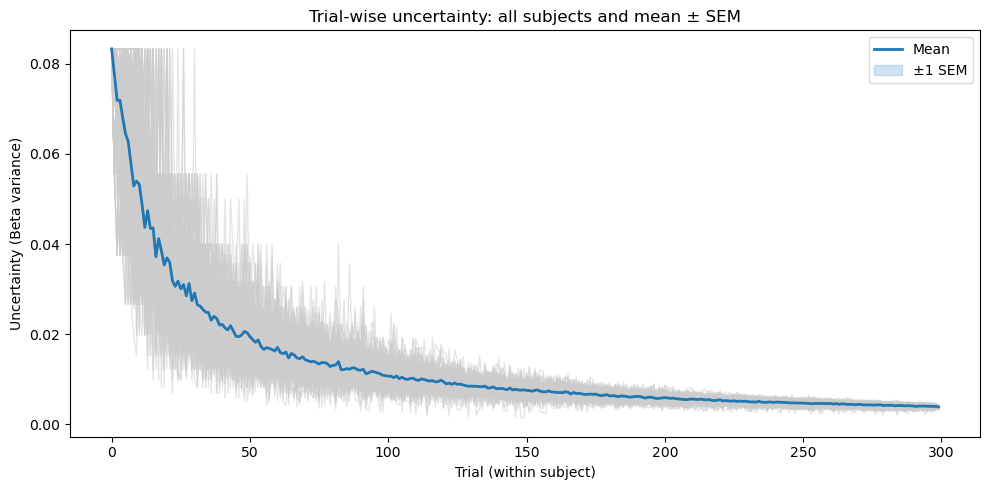

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure per-trial uncertainty exists; compute if missing
if "uncertainty" not in dataset.columns:
    unc = pd.Series(index=dataset.index, dtype=float)
    for subj, g in dataset.groupby("subj_idx", sort=False):
        unc.loc[g.index] = running_beta_variance_by_pair(g, alpha0=1.0, beta0=1.0)
    dataset["uncertainty"] = unc.astype(float)

# Build within-subject trial index (uses trial/trial_id if available)
df = dataset.copy()
sort_cols = [c for c in ["subj_idx", "trial", "trial_id"] if c in df.columns]
if sort_cols:
    df = df.sort_values(sort_cols)
df["t_within"] = df.groupby("subj_idx").cumcount()

# Summary across subjects at each trial position
summary = (
    df.groupby("t_within")["uncertainty"]
      .agg(["mean", "std", "count"])
      .reset_index()
)
summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))

# Plot: light lines per subject, mean + SEM band
plt.figure(figsize=(10, 5))

for subj, g in df.groupby("subj_idx", sort=False):
    plt.plot(g["t_within"], g["uncertainty"], color="0.8", linewidth=1, alpha=0.5)

plt.plot(summary["t_within"], summary["mean"], color="#1f77b4", linewidth=2, label="Mean")
plt.fill_between(
    summary["t_within"],
    summary["mean"] - summary["sem"],
    summary["mean"] + summary["sem"],
    color="#1f77b4",
    alpha=0.2,
    label="±1 SEM",
)

plt.xlabel("Trial (within subject)")
plt.ylabel("Uncertainty (Beta variance)")
plt.title("Trial-wise uncertainty: all subjects and mean ± SEM")
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
import numpy as np
import pandas as pd
from itertools import combinations

def beta_posterior_by_pair_from_dataset(dataset, alpha0=1.0, beta0=1.0):
    """
    Update successes/failures by pair (not by individual states) and return per-pair posteriors.
    Success = common transition (state2 equals chosen element of the presented pair).
    """
    # Build all unordered pairs and map trials to pair indices
    n = int(dataset["state2"].max()) + 1
    pairs = np.array(list(combinations(range(n), 2)), dtype=np.int64)  # (K,2)
    K = len(pairs)

    pair_idx = dataset["state1"].to_numpy(dtype=np.int64)   # 0..K-1
    resp     = dataset["response1"].to_numpy(dtype=np.int64)  # 0/1
    s2       = dataset["state2"].to_numpy(dtype=np.int64)

    trial_pairs = pairs[pair_idx]                            # (T,2)
    rows = np.arange(trial_pairs.shape[0])
    chosen_state = trial_pairs[rows, resp]                   # (T,)
    is_common = (s2 == chosen_state).astype(np.int64)        # 1=common, 0=rare

    # Aggregate counts by pair
    succ = np.bincount(pair_idx, weights=is_common.astype(float), minlength=K)
    fail = np.bincount(pair_idx, weights=(1 - is_common).astype(float), minlength=K)

    # Beta posteriors per pair
    alpha_post = alpha0 + succ
    beta_post  = beta0 + fail
    total      = succ + fail
    mean = alpha_post / (alpha_post + beta_post)
    var  = (alpha_post * beta_post) / ((alpha_post + beta_post)**2 * (alpha_post + beta_post + 1.0))

    # Tidy per-pair DataFrame
    out = pd.DataFrame({
        "pair_i": pairs[:, 0],
        "pair_j": pairs[:, 1],
        "n": total.astype(int),
        "alpha_post": alpha_post,
        "beta_post": beta_post,
        "p_common_mean": mean,
        "p_common_var": var,
    })
    return out

In [33]:
pair_stats = beta_posterior_by_pair_from_dataset(dataset, alpha0=1.0, beta0=1.0)
# ```pair_stats = beta_posterior_by_pair_from_dataset(dataset, alpha0=1.0, beta0

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

def running_beta_variance_by_state(dataset, alpha0=1.0, beta0=1.0):
    """
    Trial-wise Beta variance (uncertainty) updating by chosen STATE (piecemeal).
    Success = common transition (state2 == chosen_state).
    """
    n = int(dataset["state2"].max()) + 1
    pairs = np.array(list(combinations(range(n), 2)), dtype=np.int64)

    pair_idx = dataset["state1"].to_numpy(dtype=np.int64)
    resp     = dataset["response1"].to_numpy(dtype=np.int64)  # 0/1
    s2       = dataset["state2"].to_numpy(dtype=np.int64)

    trial_pairs = pairs[pair_idx]                 # (T,2)
    rows = np.arange(trial_pairs.shape[0])
    chosen_state = trial_pairs[rows, resp]        # (T,)
    is_common = (s2 == chosen_state).astype(np.int64)

    # Running Beta per STATE
    alpha = np.full(n, alpha0, dtype=float)
    beta  = np.full(n, beta0, dtype=float)
    var_ts = np.empty(len(pair_idx), dtype=float)

    for t, k in enumerate(chosen_state):
        a, b = alpha[k], beta[k]
        var_ts[t] = (a * b) / ((a + b)**2 * (a + b + 1.0))  # variance before observing trial t
        if is_common[t]:
            alpha[k] = a + 1.0
        else:
            beta[k] = b + 1.0
    return var_ts

def add_uncertainties_per_subject(dataset: pd.DataFrame, alpha0=1.0, beta0=1.0):
    """
    Compute both pairwise and statewise running uncertainties per subject and
    return a copy with two new columns: 'uncertainty_pair' and 'uncertainty_state'.
    """
    df = dataset.copy()
    df["uncertainty_pair"] = np.nan
    df["uncertainty_state"] = np.nan
    for subj, g in df.groupby("subj_idx", sort=False):
        # Pairwise (you already defined running_beta_variance_by_pair)
        u_pair = running_beta_variance_by_pair(g, alpha0=alpha0, beta0=beta0)
        # Statewise (piecemeal)
        u_state = running_beta_variance_by_state(g, alpha0=alpha0, beta0=beta0)
        df.loc[g.index, "uncertainty_pair"] = u_pair
        df.loc[g.index, "uncertainty_state"] = u_state
    return df.astype({"uncertainty_pair": float, "uncertainty_state": float})

def plot_uncertainty_across_subjects(dataset: pd.DataFrame, col: str, title: str = None):
    """
    Plot per-subject lines and across-subject mean±SEM for a given uncertainty column.
    """
    df = dataset.copy()
    sort_cols = [c for c in ["subj_idx", "trial", "trial_id"] if c in df.columns]
    if sort_cols:
        df = df.sort_values(sort_cols)
    df["t_within"] = df.groupby("subj_idx").cumcount()

    summary = df.groupby("t_within")[col].agg(["mean", "std", "count"]).reset_index()
    summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))

    plt.figure(figsize=(10, 5))
    for subj, g in df.groupby("subj_idx", sort=False):
        plt.plot(g["t_within"], g[col], color="0.8", linewidth=1, alpha=0.5)
    plt.plot(summary["t_within"], summary["mean"], color="#1f77b4", linewidth=2, label="Mean")
    plt.fill_between(
        summary["t_within"],
        summary["mean"] - summary["sem"],
        summary["mean"] + summary["sem"],
        color="#1f77b4", alpha=0.2, label="±1 SEM",
    )
    plt.xlabel("Trial (within subject)")
    plt.ylabel("Uncertainty (Beta variance)")
    plt.title(title or f"{col}: mean ± SEM across subjects")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_compare_pair_vs_state(dataset: pd.DataFrame, alpha0=1.0, beta0=1.0):
    """
    Overlay mean±SEM for pairwise vs. statewise (piecemeal) uncertainties across subjects.
    Computes columns if missing.
    """
    df = dataset.copy()
    if not {"uncertainty_pair", "uncertainty_state"} <= set(df.columns):
        df = add_uncertainties_per_subject(df, alpha0=alpha0, beta0=beta0)

    sort_cols = [c for c in ["subj_idx", "trial", "trial_id"] if c in df.columns]
    if sort_cols:
        df = df.sort_values(sort_cols)
    df["t_within"] = df.groupby("subj_idx").cumcount()

    def summarize(col):
        s = df.groupby("t_within")[col].agg(["mean", "std", "count"]).reset_index()
        s["sem"] = s["std"] / np.sqrt(s["count"].clip(lower=1))
        return s

    s_pair = summarize("uncertainty_pair")
    s_state = summarize("uncertainty_state")

    plt.figure(figsize=(10, 5))
    # Optional: faint per-subject lines for pairwise
    for subj, g in df.groupby("subj_idx", sort=False):
        plt.plot(g["t_within"], g["uncertainty_pair"], color="0.85", linewidth=0.8, alpha=0.4)

    # Means + SEM bands
    plt.plot(s_pair["t_within"], s_pair["mean"], color="#1f77b4", linewidth=2, label="Pairwise mean")
    plt.fill_between(
        s_pair["t_within"], s_pair["mean"] - s_pair["sem"], s_pair["mean"] + s_pair["sem"],
        color="#1f77b4", alpha=0.15,
    )
    plt.plot(s_state["t_within"], s_state["mean"], color="#d62728", linewidth=2, label="Statewise (piecemeal) mean")
    plt.fill_between(
        s_state["t_within"], s_state["mean"] - s_state["sem"], s_state["mean"] + s_state["sem"],
        color="#d62728", alpha=0.15,
    )

    plt.xlabel("Trial (within subject)")
    plt.ylabel("Uncertainty (Beta variance)")
    plt.title("Uncertainty: Pairwise vs. Statewise (piecemeal) mean ± SEM")
    plt.legend()
    plt.tight_layout()
    plt.show()

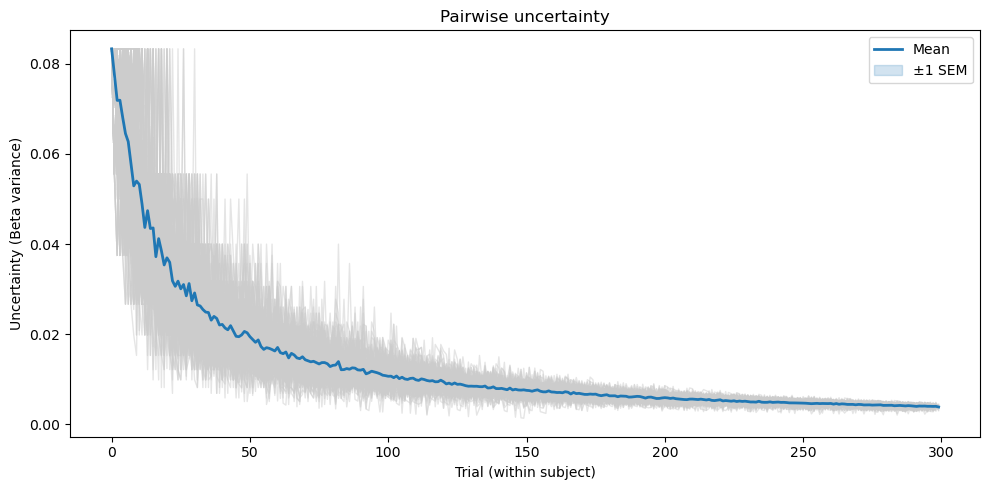

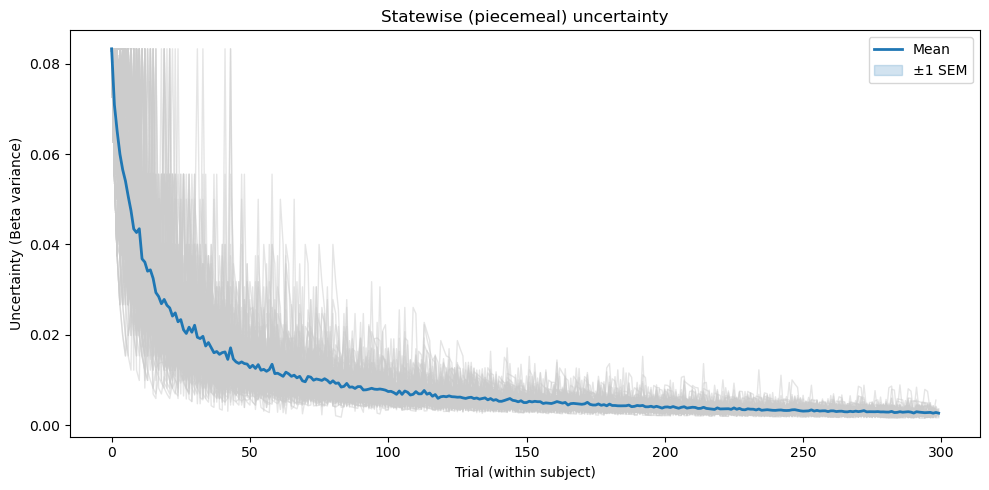

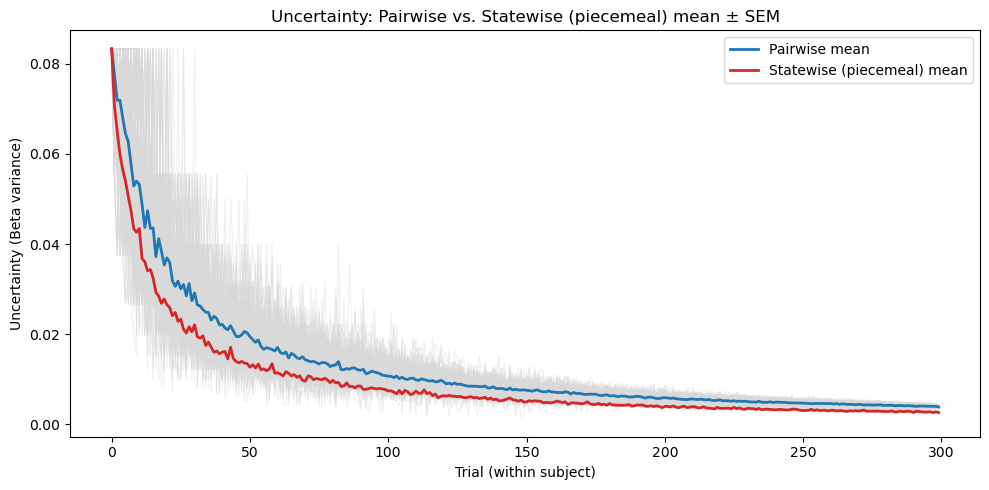

In [36]:
# Compute and attach both series, then plot
dataset = add_uncertainties_per_subject(dataset, alpha0=1.0, beta0=1.0)
plot_uncertainty_across_subjects(dataset, col="uncertainty_pair", title="Pairwise uncertainty")
plot_uncertainty_across_subjects(dataset, col="uncertainty_state", title="Statewise (piecemeal) uncertainty")
plot_compare_pair_vs_state(dataset, alpha0=1.0, beta0=1.0)

In [37]:
def append_pair_and_state_uncertainties(dataset, alpha0=1.0, beta0=1.0):
    """
    Append trial-wise uncertainties to the original DataFrame:
      - 'uncertainty_pair': pair-based updates
      - 'uncertainty_state': piecemeal (state-based) updates
    """
    df = dataset.copy()
    df["uncertainty_pair"] = np.nan
    df["uncertainty_state"] = np.nan

    for subj, g in df.groupby("subj_idx", sort=False):
        u_pair = running_beta_variance_by_pair(g, alpha0=alpha0, beta0=beta0)
        u_state = running_beta_variance_by_state(g, alpha0=alpha0, beta0=beta0)
        df.loc[g.index, "uncertainty_pair"] = u_pair
        df.loc[g.index, "uncertainty_state"] = u_state

    return df.astype({"uncertainty_pair": float, "uncertainty_state": float})

# Usage:
dataset = append_pair_and_state_uncertainties(dataset, alpha0=1.0, beta0=1.0)

In [38]:
dataset

,subj_idx,rt1,rt2,response1,response2,state1,state2,feedback,trial,cond,...,isleft1,isleft2,split_by,pair_i,pair_j,chosen_state,unchosen_state,uncertainty,uncertainty_pair,uncertainty_state
1,0.0,1.111,1.223,1.0,1.0,1.0,2.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0,2,2,0,0.083333,0.083333,0.083333
2,0.0,0.955,1.140,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0,1,1,0,0.083333,0.083333,0.083333
3,0.0,1.273,0.731,1.0,1.0,0.0,1.0,1.0,2.0,1.0,...,0.0,1.0,1.0,0,1,1,0,0.055556,0.055556,0.055556
4,0.0,0.752,0.705,0.0,1.0,3.0,1.0,1.0,3.0,1.0,...,0.0,1.0,1.0,1,2,1,2,0.083333,0.083333,0.037500
5,0.0,1.201,1.401,0.0,1.0,2.0,0.0,1.0,4.0,1.0,...,1.0,1.0,1.0,0,3,0,3,0.083333,0.083333,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30503,107.0,0.434,0.685,0.0,0.0,0.0,0.0,0.0,292.0,1.0,...,0.0,0.0,1.0,0,1,0,1,0.003576,0.003576,0.002054
30504,107.0,0.534,1.022,0.0,1.0,1.0,2.0,1.0,293.0,1.0,...,1.0,0.0,1.0,0,2,0,2,0.003953,0.003953,0.002023
30505,107.0,0.472,0.609,0.0,0.0,2.0,3.0,0.0,294.0,1.0,...,0.0,1.0,1.0,0,3,0,3,0.004620,0.004620,0.002029
30506,107.0,0.416,0.769,0.0,0.0,2.0,0.0,1.0,295.0,1.0,...,1.0,1.0,1.0,0,3,0,3,0.004584,0.004584,0.002033


In [39]:
import numpy as np
import pandas as pd
try:
    from scipy.stats import pearsonr
except Exception:
    pearsonr = None

def _residualize_linear(y: np.ndarray, t: np.ndarray) -> np.ndarray:
    """Residualize y on [1, t] using OLS."""
    X = np.column_stack([np.ones_like(t, dtype=float), t.astype(float)])
    beta, *_ = np.linalg.lstsq(X, y.astype(float), rcond=None)
    return y.astype(float) - X @ beta

def subjectwise_uncertainty_correlations(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a DataFrame with, for each subj_idx:
      - r: Pearson correlation between uncertainty_pair and uncertainty_state
      - r_partial: Pearson correlation after removing linear effect of time (within-subject)
      - n_trials: number of valid trials used
      - p, p_partial: two-sided p-values (if scipy is available)
    Requires columns: subj_idx, uncertainty_pair, uncertainty_state.
    Uses 'trial' or 'trial_id' to sort within subject if present.
    """
    req = {"uncertainty_pair", "uncertainty_state", "subj_idx"}
    missing = req - set(dataset.columns)
    if missing:
        raise ValueError(f"Missing columns: {missing}. Run append_pair_and_state_uncertainties first.")

    # Sort within subject by available trial order
    df = dataset.copy()
    sort_cols = [c for c in ["subj_idx", "trial", "trial_id"] if c in df.columns]
    if sort_cols:
        df = df.sort_values(sort_cols)
    df["t_within"] = df.groupby("subj_idx").cumcount()

    rows = []
    for subj, g in df.groupby("subj_idx", sort=False):
        x = g["uncertainty_pair"].to_numpy()
        y = g["uncertainty_state"].to_numpy()
        t = g["t_within"].to_numpy()

        m = np.isfinite(x) & np.isfinite(y) & np.isfinite(t)
        x, y, t = x[m], y[m], t[m]
        n = len(x)
        if n < 3:
            rows.append({"subj_idx": subj, "n_trials": n, "r": np.nan, "p": np.nan,
                         "r_partial": np.nan, "p_partial": np.nan})
            continue

        # Simple Pearson
        if pearsonr is not None:
            r, p = pearsonr(x, y)
        else:
            r = np.corrcoef(x, y)[0, 1]
            p = np.nan

        # Partial (residualize both on time)
        xr = _residualize_linear(x, t)
        yr = _residualize_linear(y, t)
        if pearsonr is not None:
            r_part, p_part = pearsonr(xr, yr)
        else:
            r_part = np.corrcoef(xr, yr)[0, 1]
            p_part = np.nan

        rows.append({
            "subj_idx": subj,
            "n_trials": int(n),
            "r": float(r),
            "p": float(p),
            "r_partial": float(r_part),
            "p_partial": float(p_part),
        })

    return pd.DataFrame(rows).sort_values("subj_idx").reset_index(drop=True)

# Usage:
# corr_df = subjectwise_uncertainty_correlations(dataset)
# corr_df

In [40]:
corr_df = subjectwise_uncertainty_correlations(dataset)
corr_df

,subj_idx,n_trials,r,p,r_partial,p_partial
0,0.0,299,0.809267,1.376526e-70,0.681916,3.084303e-42
1,1.0,296,0.895793,1.517580e-105,0.824218,1.380579e-74
2,2.0,295,0.833895,1.309109e-77,0.738543,4.313822e-52
3,3.0,300,0.768760,8.428992e-60,0.664776,1.249899e-39
4,4.0,300,0.867560,2.121692e-92,0.757274,4.442872e-57
...,...,...,...,...,...,...
98,103.0,293,0.813123,2.350595e-70,0.679575,4.845266e-41
99,104.0,300,0.908510,5.945867e-115,0.838512,1.441773e-80
100,105.0,299,0.879908,5.461545e-98,0.772541,1.559652e-60
101,106.0,300,0.838883,1.053596e-80,0.737033,1.237230e-52


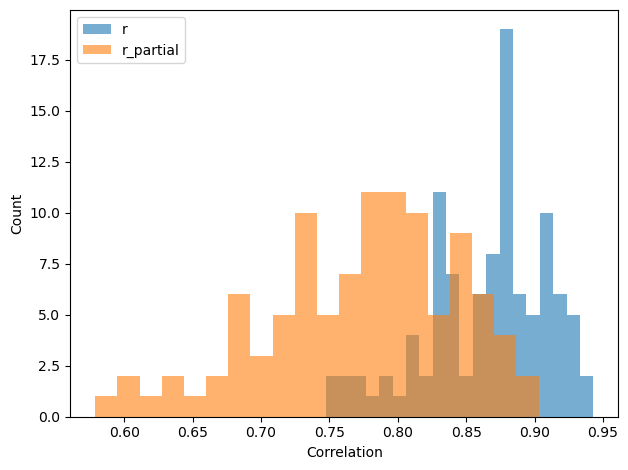

In [43]:
# ...existing code...
import numpy as np
import pandas as pd

def summarize_correlations(corr_df: pd.DataFrame, n_boot: int = 5000, random_state: int = 0) -> pd.Series:
    r = corr_df["r"].to_numpy()
    rp = corr_df["r_partial"].to_numpy() if "r_partial" in corr_df else np.array([])

    r = r[np.isfinite(r)]
    rp = rp[np.isfinite(rp)]

    def boot_ci(x):
        if x.size < 2:
            return (np.nan, np.nan)
        rng = np.random.default_rng(random_state)
        idx = rng.integers(0, x.size, size=(n_boot, x.size))
        boots = x[idx].mean(axis=1)
        lo, hi = np.percentile(boots, [2.5, 97.5])
        return float(lo), float(hi)

    def fisher_mean(x):
        if x.size == 0:
            return np.nan
        x = np.clip(x, -0.999999, 0.999999)
        z = np.arctanh(x)
        return float(np.tanh(z.mean()))

    r_lo, r_hi = boot_ci(r) if r.size else (np.nan, np.nan)
    rp_lo, rp_hi = boot_ci(rp) if rp.size else (np.nan, np.nan)

    out = {
        "n_subjects": int(r.size),
        "r_mean": float(np.mean(r)) if r.size else np.nan,
        "r_median": float(np.median(r)) if r.size else np.nan,
        "r_ci95_lo": r_lo,
        "r_ci95_hi": r_hi,
        "r_pos_frac": float(np.mean(r > 0)) if r.size else np.nan,
        "r_sig_frac": float(np.mean(corr_df["p"] < 0.05)) if "p" in corr_df else np.nan,
        "r_fisher_mean": fisher_mean(r),
        "r_partial_mean": float(np.mean(rp)) if rp.size else np.nan,
        "r_partial_median": float(np.median(rp)) if rp.size else np.nan,
        "r_partial_ci95_lo": rp_lo,
        "r_partial_ci95_hi": rp_hi,
        "r_partial_pos_frac": float(np.mean(rp > 0)) if rp.size else np.nan,
        "r_partial_sig_frac": float(np.mean(corr_df.get("p_partial", np.full(len(corr_df), np.nan)) < 0.05))
                              if "p_partial" in corr_df else np.nan,
        "r_partial_fisher_mean": fisher_mean(rp),
    }
    return pd.Series(out)

summary = summarize_correlations(corr_df)
summary

# ...existing code...
import matplotlib.pyplot as plt
plt.hist(corr_df["r"].dropna(), bins=20, alpha=0.6, label="r")
plt.hist(corr_df["r_partial"].dropna(), bins=20, alpha=0.6, label="r_partial")
plt.xlabel("Correlation")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()


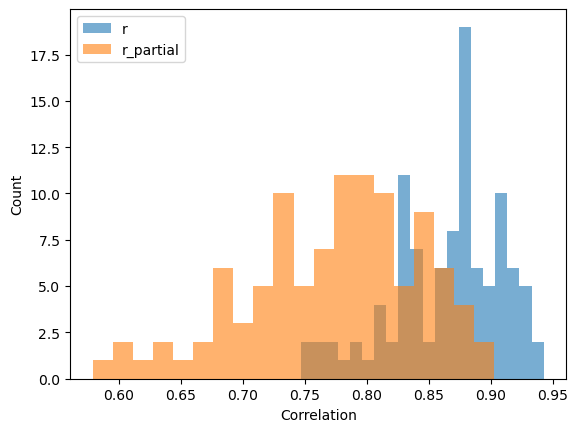

In [44]:
# ```# ...existing code.../
import matplotlib.pyplot as plt
plt.hist(corr_df["r"].dropna(), bins=20, alpha=0.6, label="r")
plt.hist(corr_df["r_partial"].dropna(), bins=20, alpha=0.6, label="r_partial")
plt.xlabel("Correlation")
plt.ylabel("Count")
plt.legend()

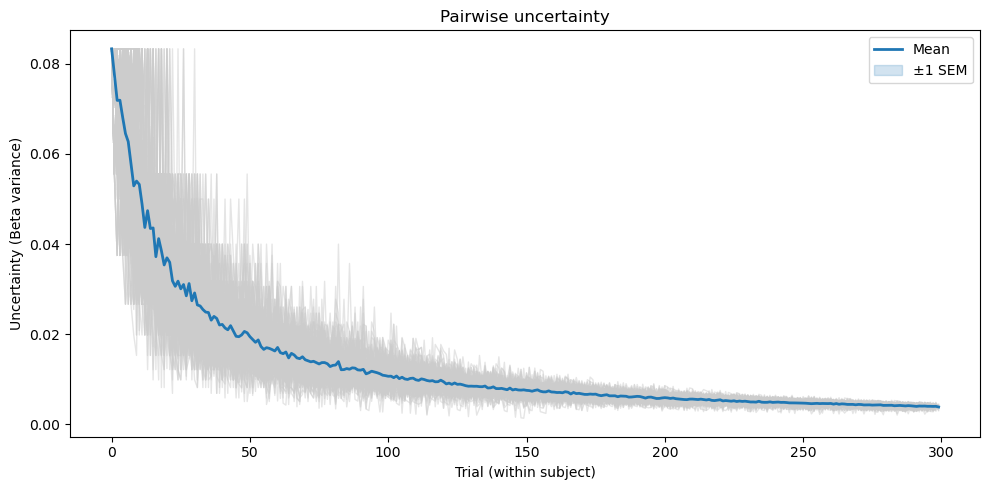

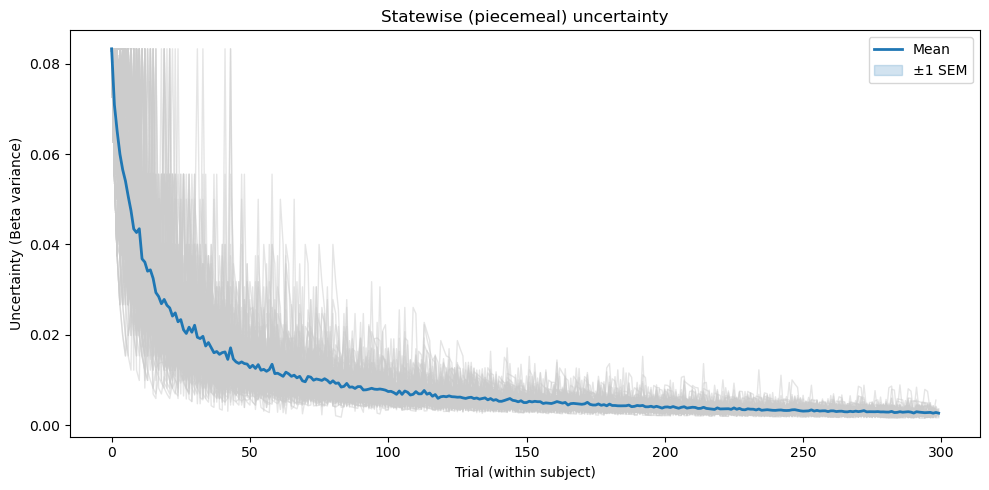

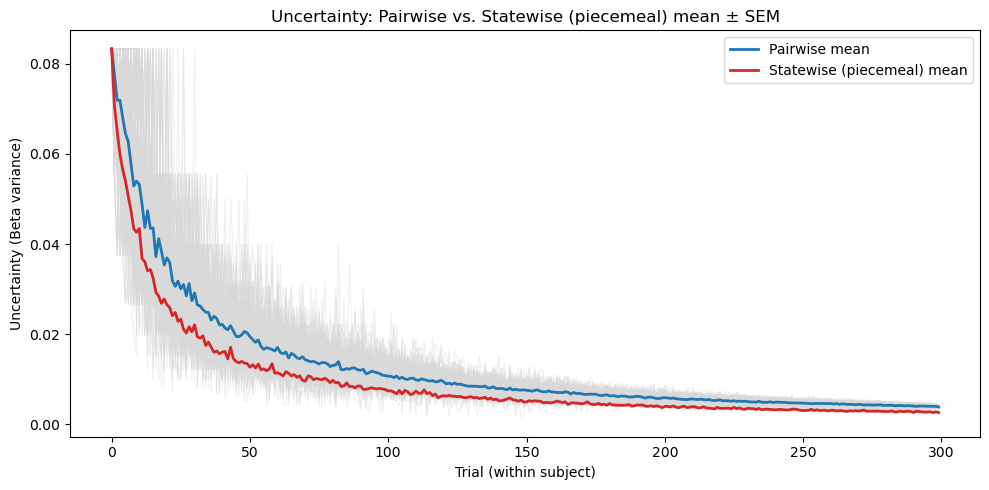

In [45]:
# Ensure uncertainties exist, then plot time series
if not {"uncertainty_pair","uncertainty_state"} <= set(dataset.columns):
    dataset = add_uncertainties_per_subject(dataset, alpha0=1.0, beta0=1.0)

plot_uncertainty_across_subjects(dataset, col="uncertainty_pair", title="Pairwise uncertainty")
plot_uncertainty_across_subjects(dataset, col="uncertainty_state", title="Statewise (piecemeal) uncertainty")
plot_compare_pair_vs_state(dataset, alpha0=1.0, beta0=1.0)

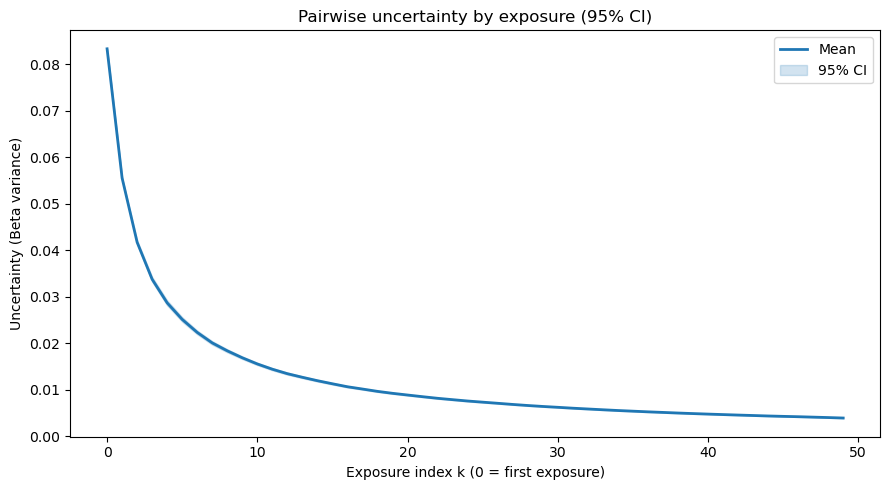

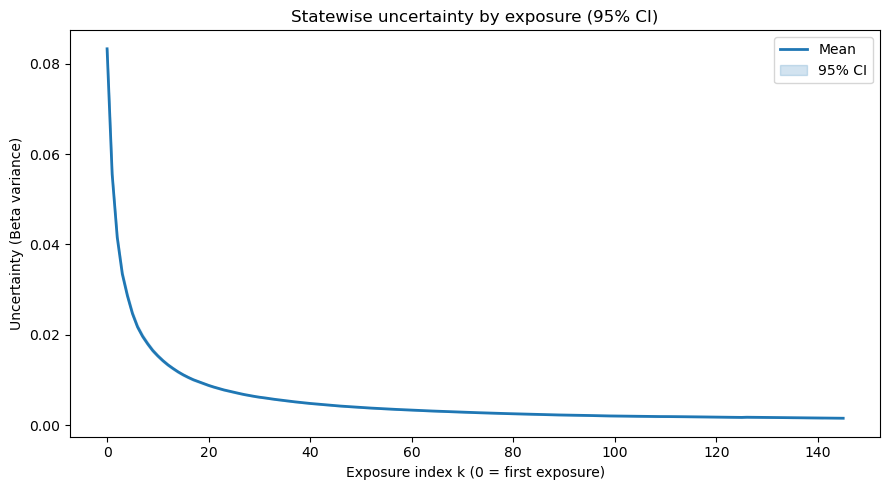

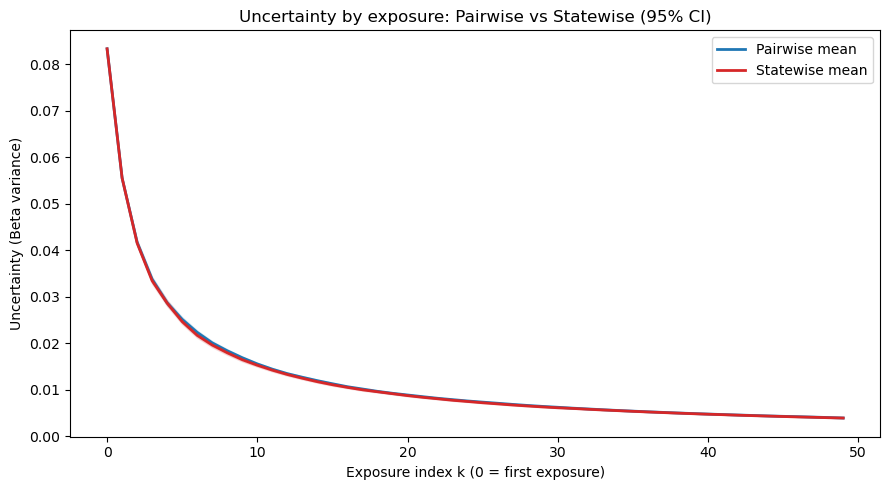

n_k              50.000000
mean_abs_diff     0.000136
rmse              0.000195
corr              0.999954
dtype: float64

In [46]:
# ...existing code...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

def _ensure_chosen_state(df: pd.DataFrame) -> pd.DataFrame:
    if "chosen_state" in df.columns:
        return df
    n = int(df["state2"].max()) + 1
    pairs = np.array(list(combinations(range(n), 2)), dtype=np.int64)
    pair_idx = df["state1"].to_numpy(dtype=np.int64)
    resp = df["response1"].to_numpy(dtype=np.int64)
    trial_pairs = pairs[pair_idx]
    rows = np.arange(len(df))
    chosen_state = trial_pairs[rows, resp]
    df = df.copy()
    df["chosen_state"] = chosen_state
    return df

def add_exposure_indices(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Adds:
      - exp_by_pair: kth exposure of that pair (state1) within subject
      - exp_by_state: kth exposure of the chosen state within subject
    """
    df = _ensure_chosen_state(dataset)
    df = df.copy()
    df["exp_by_pair"] = df.groupby(["subj_idx", "state1"]).cumcount()
    df["exp_by_state"] = df.groupby(["subj_idx", "chosen_state"]).cumcount()
    return df

def _subject_mean_by_exposure(df: pd.DataFrame, value_col: str, exposure_col: str) -> pd.DataFrame:
    """
    For each subject and exposure index k, average the value across all units having that k.
    Returns long DF: [subj_idx, k, value_mean]
    """
    tmp = (
        df.groupby(["subj_idx", exposure_col])[value_col]
          .mean()
          .reset_index()
          .rename(columns={exposure_col: "k", value_col: "value"})
    )
    return tmp

def summarize_by_exposure(df: pd.DataFrame, value_col: str, exposure_col: str) -> pd.DataFrame:
    subj_means = _subject_mean_by_exposure(df, value_col, exposure_col)
    summary = (
        subj_means.groupby("k")["value"]
        .agg(["mean", "std", "count"])
        .reset_index()
    )
    summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
    summary["ci95_lo"] = summary["mean"] - 1.96 * summary["sem"]
    summary["ci95_hi"] = summary["mean"] + 1.96 * summary["sem"]
    return summary

def plot_uncertainty_by_exposure(dataset: pd.DataFrame, value_col: str, exposure_col: str, title: str):
    """
    Plots across-subject mean ± 95% CI aligned by kth exposure.
    """
    df = add_exposure_indices(dataset)
    s = summarize_by_exposure(df, value_col=value_col, exposure_col=exposure_col)

    plt.figure(figsize=(9, 5))
    plt.plot(s["k"], s["mean"], color="#1f77b4", lw=2, label="Mean")
    plt.fill_between(s["k"], s["ci95_lo"], s["ci95_hi"], color="#1f77b4", alpha=0.2, label="95% CI")
    plt.xlabel("Exposure index k (0 = first exposure)")
    plt.ylabel("Uncertainty (Beta variance)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return s

def plot_compare_by_exposure(dataset: pd.DataFrame):
    """
    Overlays pairwise vs statewise mean ± 95% CI by exposure index.
    """
    df = add_exposure_indices(dataset)
    s_pair = summarize_by_exposure(df, "uncertainty_pair", "exp_by_pair")
    s_state = summarize_by_exposure(df, "uncertainty_state", "exp_by_state")

    # Align ks that both have
    k_common = np.intersecting_arcs = np.intersect1d(s_pair["k"].to_numpy(), s_state["k"].to_numpy())
    s_pair_c = s_pair[s_pair["k"].isin(k_common)]
    s_state_c = s_state[s_state["k"].isin(k_common)]

    plt.figure(figsize=(9, 5))
    # Pairwise
    plt.plot(s_pair_c["k"], s_pair_c["mean"], color="#1f77b4", lw=2, label="Pairwise mean")
    plt.fill_between(s_pair_c["k"], s_pair_c["ci95_lo"], s_pair_c["ci95_hi"], color="#1f77b4", alpha=0.15)
    # Statewise
    plt.plot(s_state_c["k"], s_state_c["mean"], color="#d62728", lw=2, label="Statewise mean")
    plt.fill_between(s_state_c["k"], s_state_c["ci95_lo"], s_state_c["ci95_hi"], color="#d62728", alpha=0.15)

    plt.xlabel("Exposure index k (0 = first exposure)")
    plt.ylabel("Uncertainty (Beta variance)")
    plt.title("Uncertainty by exposure: Pairwise vs Statewise (95% CI)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return s_pair, s_state

def exposure_overlap_metrics(s_pair: pd.DataFrame, s_state: pd.DataFrame) -> pd.Series:
    """
    Simple overlap metric on the exposure-aligned means.
    Returns L1 and L2 differences and correlation across k.
    """
    k_common = np.intersect1d(s_pair["k"].to_numpy(), s_state["k"].to_numpy())
    a = s_pair.set_index("k").loc[k_common, "mean"].to_numpy()
    b = s_state.set_index("k").loc[k_common, "mean"].to_numpy()
    if a.size == 0:
        return pd.Series({"n_k": 0, "mean_abs_diff": np.nan, "rmse": np.nan, "corr": np.nan})
    corr = np.corrcoef(a, b)[0, 1] if a.size > 1 else np.nan
    return pd.Series({
        "n_k": int(a.size),
        "mean_abs_diff": float(np.mean(np.abs(a - b))),
        "rmse": float(np.sqrt(np.mean((a - b) ** 2))),
        "corr": float(corr),
    })

# Usage:
# 1) Make sure uncertainties exist
if not {"uncertainty_pair","uncertainty_state"} <= set(dataset.columns):
    dataset = add_uncertainties_per_subject(dataset, alpha0=1.0, beta0=1.0)

# 2) Exposure-aligned plots
s_pair = plot_uncertainty_by_exposure(dataset, "uncertainty_pair", "exp_by_pair",
                                      title="Pairwise uncertainty by exposure (95% CI)")
s_state = plot_uncertainty_by_exposure(dataset, "uncertainty_state", "exp_by_state",
                                       title="Statewise uncertainty by exposure (95% CI)")

# 3) Overlay and overlap stats
sp, ss = plot_compare_by_exposure(dataset)
overlap = exposure_overlap_metrics(sp, ss)
overlap
# ...existing code...

In [ ]:
def get_conj_uncertainty(dataset):
    # ssc = int(max(dataset['state2'])+1)
    # Number of states (assumes 0-based labels in state2)
    n = int(dataset["state2"].max()) + 1

    # All unordered pairs (0..n-1 choose 2)
    pairs = np.array(list(combinations(range(n), 2)), dtype=np.int64)  # shape: (n*(n-1)//2, 2)

    idx = dataset["state1"].to_numpy(dtype=np.int64)
    trial_pairs = pairs[idx]  # shape: (n_trials, 2)
    
    # 3) Which element of that pair was chosen (0-based already)
    resp = dataset["response1"].to_numpy(dtype=np.int64) 
  
    # 4) Index chosen/unchosen states
    rows = np.arange(trial_pairs.shape[0])
    chosen_state = trial_pairs[rows, resp]          # (T,)
    unchosen_state = trial_pairs[rows, 1 - resp]    # (T,)  
    
   # 5) (Optional) Attach to DataFrame
    dataset["pair_i"] = trial_pairs[:, 0]
    dataset["pair_j"] = trial_pairs[:, 1]
    dataset["chosen_state"] = chosen_state
    dataset["unchosen_state"] = unchosen_state
    return dataset

In [14]:
def beta_posterior_by_pair(pair_idx, is_common, K, alpha0=1.0, beta0=1.0):
    # Vectorized counts per pair
    succ = np.bincount(pair_idx, weights=is_common.astype(float), minlength=K)
    fail = np.bincount(pair_idx, weights=(1 - is_common).astype(float), minlength=K)
    alpha_post = alpha0 + succ
    beta_post  = beta0 + fail
    var = (alpha_post * beta_post) / ((alpha_post + beta_post)**2 * (alpha_post + beta_post + 1.0))
    mean = alpha_post / (alpha_post + beta_post)
    return alpha_post, beta_post, mean, var


In [15]:
n = int(dataset["state2"].max()) + 1

# All unordered pairs (0..n-1 choose 2)
pairs = np.array(list(combinations(range(n), 2)), dtype=np.int64)  # shape: (n*(n-1)//2, 2)

idx = dataset["state1"].to_numpy(dtype=np.int64)
trial_pairs = pairs[idx]  # shape: (n_trials, 2)

# 3) Which element of that pair was chosen (0-based already)
resp = dataset["response1"].to_numpy(dtype=np.int64) 

# 4) Index chosen/unchosen states
rows = np.arange(trial_pairs.shape[0])
chosen_state = trial_pairs[rows, resp]          # (T,)
unchosen_state = trial_pairs[rows, 1 - resp]    # (T,)  

# 5) (Optional) Attach to DataFrame
dataset["pair_i"] = trial_pairs[:, 0]
dataset["pair_j"] = trial_pairs[:, 1]
dataset["chosen_state"] = chosen_state
dataset["unchosen_state"] = unchosen_state

In [18]:
is_common = (dataset['state2'] == dataset['chosen_state']).astype(np.int64)   
np.mean(is_common)# 1=common, 0=rare
K = len(pairs)

In [19]:
alpha_post, beta_post, p_common_mean, p_common_var = beta_posterior_by_pair(idx, is_common, K, alpha0=1.0, beta0=1.0)


In [24]:
p_common_var

array([4.15868070e-05, 3.99488101e-05, 4.18143596e-05, 4.08713163e-05,
       4.02052074e-05, 4.16034997e-05])

In [12]:
# Number of states (assumes 0-based labels in state2)
n = int(dataset["state2"].max()) + 1

# All unordered pairs (0..n-1 choose 2)
pairs = np.array(list(combinations(range(n), 2)), dtype=np.int64)  # shape: (n*(n-1)//2, 2)

idx = dataset["state1"].to_numpy(dtype=np.int64)
trial_pairs = pairs[idx]  # shape: (n_trials, 2)

In [ ]:
trial_pairs[]

array([[0, 2],
       [0, 1],
       [0, 1],
       ...,
       [0, 3],
       [0, 3],
       [1, 3]], shape=(30507, 2))

In [10]:
pairs[dataset['state1']]

TypeError: list indices must be integers or slices, not Series

In [9]:
max(dataset['state2'])+1

4.0